# Distributed alternating direction method of multipliers (ADMM)

In [57]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors
import opendssdirect as dss
from post_process.model_utils import ModelUtil
import pandas as pd
import json
import os
from oedisi.componentframework import wiring_diagram_utils
from oedisi.types.data_types import (
    Topology
)
from post_process import plotter
from dataclasses import dataclass
from pprint import pprint

ROOT = os.getcwd()
OUTPUTS = f"{ROOT}/outputs"
SCENARIO_DIR, SCENARIOS, _ = next(os.walk(f'{ROOT}/scenario/'))

print(SCENARIO_DIR)
for idx, scenario in enumerate(SCENARIOS):
    print(idx, scenario)

/home/tylor/dev/oedisi_dopf/scenario/
0 medium_extreme
1 large
2 omoo
3 medium
4 omoo_medium
5 omoo_medium_extreme
6 small
7 ieee123
8 omoo_small


## Select a scenario
Set the SCENARIOS index value from the available scenarios

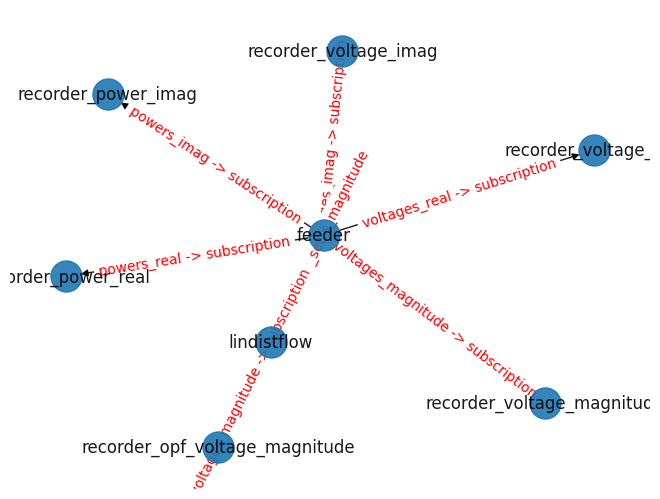

In [58]:
index = 1
SCENARIO = SCENARIOS[index]

path = f"{SCENARIO_DIR}{SCENARIO}"
with open(f"{path}/system.json") as f:
    wiring_diagram = wiring_diagram_utils.WiringDiagram.parse_obj(json.load(f))

wiring_diagram_utils.plot_graph_matplotlib(wiring_diagram)

## Build the selected scenario
The build will create a new build_<scenario> folder and copy over the federate files as specified. Assume successful build if no errors are presented.

In [59]:
os.system(f"oedisi build --system {path}/system.json --component-dict {path}/components.json --target-directory build_{SCENARIO}")

Loading the components defined in /home/tylor/dev/oedisi_dopf/scenario/ieee123/components.json
Loading system json /home/tylor/dev/oedisi_dopf/scenario/ieee123/system.json
Building system in build_ieee123


0

## Model Topology
split model into areas using discconnection switches

In [60]:
def init_branch() -> dict:
    branch = {}
    branch["fr_bus"] = ""
    branch["to_bus"] = ""
    branch["phases"] = []
    branch["type"] = ""
    return branch

@dataclass
class SwitchInfo:
    name: str
    from_bus: str
    to_bus: str


def extract_switches(incidences: dict) -> list[SwitchInfo]:
    switches = []
    from_eq = incidences["from_equipment"]
    to_eq = incidences["to_equipment"]
    ids = incidences["ids"]
    for fr_eq, to_eq, eq_id in zip(from_eq, to_eq, ids):
        if "sw" in eq_id and "padswitch" not in eq_id:
            if "." in fr_eq:
                [fr_eq, _] = fr_eq.split('.',1)
            if "." in to_eq:
                [to_eq, _] = to_eq.split('.',1)
            switches.append(
                SwitchInfo(
                    name=eq_id, 
                    from_bus=fr_eq, 
                    to_bus=to_eq))   

    return switches
    
def extract_info(topology: Topology,switches: list[SwitchInfo]) -> dict:
    branch_info = {}
    from_equip = topology.admittance.from_equipment
    to_equip = topology.admittance.to_equipment
    fr_buses = [switch.from_bus for switch in switches]
    to_buses = [switch.to_bus for switch in switches]

    for fr_eq, to_eq in zip(from_equip, to_equip):
        type = "LINE"
        [from_name, from_phase] = fr_eq.split('.')
        [to_name, to_phase] = to_eq.split('.')

        forward_link = from_name in fr_buses and to_name in to_buses
        reverse_link = to_name in fr_buses and from_name in to_buses
        if forward_link or reverse_link:
            type = "SWITCH"

        if from_name == to_name:
            continue

        key = f"{from_name}_{to_name}"
        key_back = f"{to_name}_{from_name}"

        if key not in branch_info and key_back not in branch_info:
            branch_info[key] = init_branch()
        elif key_back in branch_info:
            continue

        if from_phase not in branch_info[key]['phases']:
            branch_info[key]['phases'].append(from_phase)

        branch_info[key]['type'] = type
        branch_info[key]['fr_bus'] = from_name.upper()
        branch_info[key]['to_bus'] = to_name.upper()

    return branch_info

topology_file = f"{OUTPUTS}/{SCENARIO}/topology.json"
with open(topology_file) as f:
    topology = json.load(f)
    incidences = topology["incidences"]
    switches = extract_switches(incidences)
    pprint(switches)
    topology = Topology.parse_obj(topology)


branch = extract_info(topology, switches)
for k,v in branch.items():
    if v["type"] == "SWITCH":
        print(k, v)

[SwitchInfo(name='sw1', from_bus='150R', to_bus='149'),
 SwitchInfo(name='sw2', from_bus='13', to_bus='152'),
 SwitchInfo(name='sw3', from_bus='18', to_bus='135'),
 SwitchInfo(name='sw4', from_bus='60', to_bus='160'),
 SwitchInfo(name='sw5', from_bus='97', to_bus='197'),
 SwitchInfo(name='sw6', from_bus='61', to_bus='61S'),
 SwitchInfo(name='sw7', from_bus='151', to_bus='300_OPEN'),
 SwitchInfo(name='sw8', from_bus='54', to_bus='94_OPEN')]
149_150R {'fr_bus': '149', 'to_bus': '150R', 'phases': ['1', '2', '3'], 'type': 'SWITCH'}
152_13 {'fr_bus': '152', 'to_bus': '13', 'phases': ['1', '2', '3'], 'type': 'SWITCH'}
135_18 {'fr_bus': '135', 'to_bus': '18', 'phases': ['1', '2', '3'], 'type': 'SWITCH'}
300_OPEN_151 {'fr_bus': '300_OPEN', 'to_bus': '151', 'phases': ['1', '2', '3'], 'type': 'SWITCH'}
94_OPEN_54 {'fr_bus': '94_OPEN', 'to_bus': '54', 'phases': ['1'], 'type': 'SWITCH'}
160_60 {'fr_bus': '160', 'to_bus': '60', 'phases': ['1', '2', '3'], 'type': 'SWITCH'}
61S_61 {'fr_bus': '61S', '

## Areas

1 Graph with 38 nodes and 37 edges (1.0, 0.918918918918919, 0.0, 1.0)
2 Graph with 19 nodes and 18 edges (0.0, 1.0, 0.0, 1.0)
3 Graph with 16 nodes and 15 edges (0.0, 0.9239130434782604, 1.0, 1.0)
4 Graph with 37 nodes and 36 edges (0.16304347826086973, 0.0, 1.0, 1.0)
5 Graph with 16 nodes and 15 edges (1.0, 0.0, 0.75, 1.0)
Areas:  [37, 19, 16, 16]
[SwitchInfo(name='sw1', from_bus='150R', to_bus='149'),
 SwitchInfo(name='sw2', from_bus='13', to_bus='152'),
 SwitchInfo(name='sw3', from_bus='18', to_bus='135'),
 SwitchInfo(name='sw4', from_bus='60', to_bus='160'),
 SwitchInfo(name='sw5', from_bus='97', to_bus='197'),
 SwitchInfo(name='sw6', from_bus='61', to_bus='61S'),
 SwitchInfo(name='sw7', from_bus='151', to_bus='300_OPEN'),
 SwitchInfo(name='sw8', from_bus='54', to_bus='94_OPEN')]
1 Graph with 38 nodes and 37 edges (1.0, 0.918918918918919, 0.0, 1.0)
2 Graph with 19 nodes and 18 edges (0.0, 1.0, 0.0, 1.0)
3 Graph with 16 nodes and 15 edges (0.0, 0.9239130434782604, 1.0, 1.0)
4 Graph 

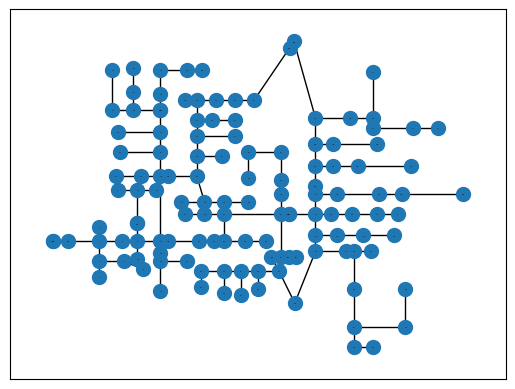

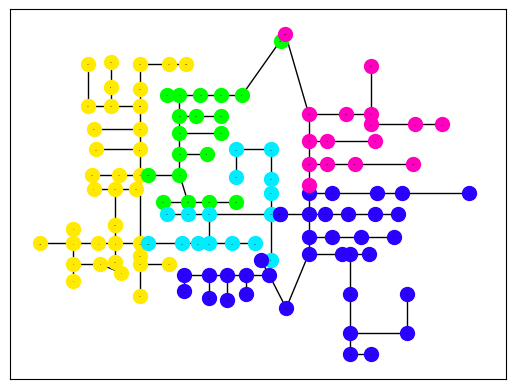

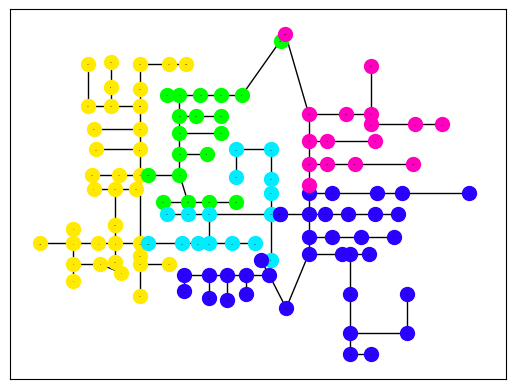

In [61]:
coords_file = f"{OUTPUTS}/{SCENARIO}/BusCoords.dat"
pos = {}
with open(coords_file) as f:
   for line in f:
       values = line.split()
       if len(values) == 3:
           x = float(values[1])
           y = float(values[2])
           pos[values[0].upper()] = (x,y)
    
full_graph = nx.Graph()
for b in branch:
    fr_bus = branch[b]["fr_bus"]
    to_bus = branch[b]["to_bus"]
    if fr_bus in pos.keys() and to_bus in pos.keys():
        full_graph.add_edge(fr_bus, to_bus)

options = {
    "font_size": 1,
    "node_size": 100,
    "linewidths": 1,
    "width": 1,
}
nx.draw_networkx(full_graph, pos, **options)
        
dissconnected_graph = nx.Graph()
for b in branch:
    if branch[b]['type'] != 'SWITCH':
        dissconnected_graph.add_edge(branch[b]['fr_bus'],
                       branch[b]['to_bus'])

sp_graph = list(nx.connected_components(dissconnected_graph))

areas = {}
area_idx = 0
for k in sp_graph:
    if len(k) > 2:
        area_idx += 1
        area = nx.Graph()
        for b in branch:
            fr_bus = branch[b]["fr_bus"]
            to_bus = branch[b]["to_bus"]
            if fr_bus in k and to_bus in k:
                area.add_edge(fr_bus, to_bus)
        areas[area_idx] = area
    
cmap = plt.colormaps['gist_rainbow']
area_count = len(areas)
fig, ax = plt.subplots()
for k,v in areas.items():
    c = cmap(k/area_count)
    print(k,v,c)
    nx.draw_networkx(v, pos, **options, node_color=c)

area_nodes = [area.number_of_nodes() for area in areas.values()]
area_nodes.sort(reverse=True)
print("Areas: ", area_nodes[1:13])


for k,v in areas.items():
    if v.number_of_nodes() < min(area_nodes[1:13]):
        fr_buses = [switch.from_bus for switch in switches]
        to_buses = [switch.to_bus for switch in switches]
        edges = v.edges()
        for e1,e2 in edges:
            switches = [switch for switch in switches if e1 not in switch.name.upper()]
            switches = [switch for switch in switches if e2 not in switch.name.upper()]

pprint(switches)
branch = extract_info(topology, switches)
dissconnected_graph = nx.Graph()
for b in branch:
    if branch[b]['type'] != 'SWITCH':
        dissconnected_graph.add_edge(branch[b]['fr_bus'],
                       branch[b]['to_bus'])

sp_graph = list(nx.connected_components(dissconnected_graph))

areas = {}
area_idx = 0
for k in sp_graph:
    if len(k) > 2:
        area_idx += 1
        area = nx.Graph()
        for b in branch:
            fr_bus = branch[b]["fr_bus"]
            to_bus = branch[b]["to_bus"]
            if fr_bus in k and to_bus in k:
                area.add_edge(fr_bus, to_bus)
        areas[area_idx] = area
    
cmap = plt.colormaps['gist_rainbow']
area_count = len(areas)
fig, ax = plt.subplots()
for k,v in areas.items():
    c = cmap(k/area_count)
    print(k,v,c)
    nx.draw_networkx(v, pos, **options, node_color=c)

## Run selected scenario
The simulation will take 5-30 minutes to run depending on the scenario. The results will print Done once complete.

In [62]:
os.system("pkill -9 helics_broker")
os.system(f"oedisi run --runner build_{SCENARIO}/system_runner.json")

[warn] helics-cli's web interface is not installed. You may want to run `pip install "helics[cli]"`.
[warn] helics-cli's observer functionality is not installed. You may want to run `pip install "helics[cli]"`.
[info] Running federation: ieee123
[info] Running federate recorder_power_real as a background process
[info] Running federate recorder_power_imag as a background process
[info] Running federate recorder_voltage_real as a background process
[info] Running federate recorder_voltage_imag as a background process
[info] Running federate recorder_voltage_magnitude as a background process
[info] Running federate recorder_opf_voltage_magnitude as a background process
[info] Running federate feeder as a background process
[info] Running federate lindistflow as a background process
[info] Running federate broker as a background process
[info] Waiting for 9 processes to finish ...
[error] Process feeder has failed, killing other processes
[error] Process feeder exited with return code 1
[

0